# **K-Nearest Neighbors**

In this exercise, you will build a classifier using the K-Nearest Neighbors algorithm.

---

### **1. Generating data**


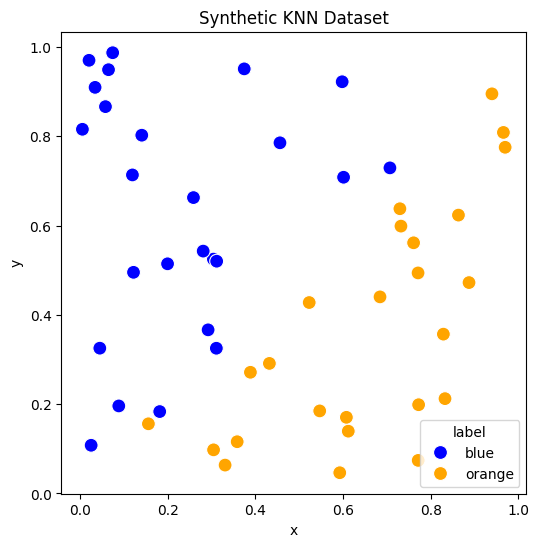

In [1]:
# 1. Generate synthetic data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
n = 50
# Generate random points in unit square
X = np.random.rand(n, 2)
# Define a boundary: x > y -> orange, else blue
labels = np.where(X[:, 0] > X[:, 1], 'orange', 'blue')
df = pd.DataFrame(X, columns=['x', 'y'])
df['label'] = labels

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette={'orange':'orange', 'blue':'blue'}, s=100)
plt.title('Synthetic KNN Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### **2. The algorithm**
Let's define the KNN classifier from scratch and run experiments for several values of K.

In [1]:
# 2. Implement KNN algorithm for a new point
from collections import Counter

def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def manhattan_distance(p1, p2):
    return np.sum(np.abs(p1 - p2))

def knn_predict(X, y, x0, K=3, metric='euclidean'):
    if metric == 'euclidean':
        dists = np.linalg.norm(X - x0, axis=1)
    elif metric == 'manhattan':
        dists = np.sum(np.abs(X - x0), axis=1)
    else:
        raise ValueError('Unknown metric')
    idx = np.argsort(dists)[:K]
    neighbor_labels = y[idx]
    pred = Counter(neighbor_labels).most_common(1)[0][0]
    return pred, neighbor_labels, dists[idx]


#### Predict the label for a new random point and visualize neighbors for different K

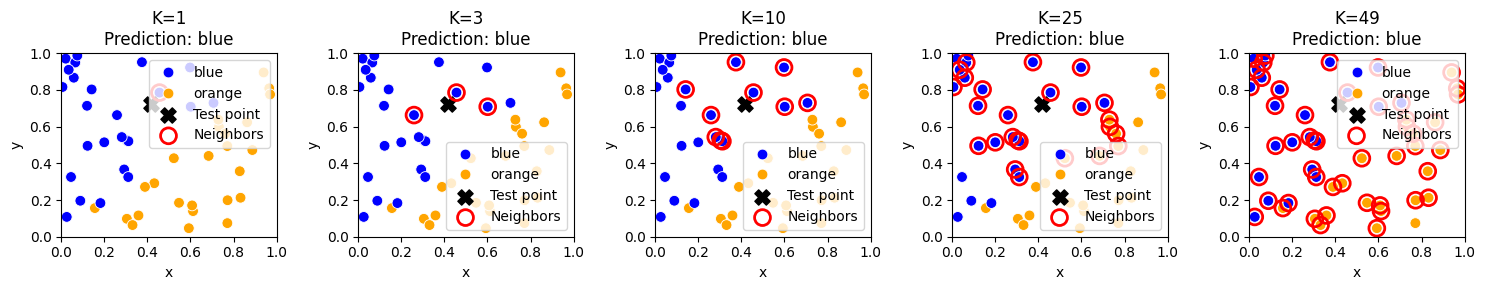

In [3]:
np.random.seed(1)
x0 = np.random.rand(2)

K_list = [1, 3, 10, 25, 49]
results = {}
plt.figure(figsize=(15, 3))
for i, K in enumerate(K_list):
    pred, neighbors, neighbor_dists = knn_predict(X, labels, x0, K=K)
    results[K] = pred
    ax = plt.subplot(1, len(K_list), i+1)
    sns.scatterplot(data=df, x='x', y='y', hue='label', palette={'orange':'orange', 'blue':'blue'}, s=60, ax=ax)
    ax.scatter(x0[0], x0[1], color='k', marker='X', s=120, label='Test point')
    # Highlight neighbors
    idx = np.argsort(np.linalg.norm(X - x0, axis=1))[:K]
    ax.scatter(X[idx,0], X[idx,1], facecolors='none', edgecolors='r', s=130, linewidths=2, label='Neighbors')
    ax.set_title(f'K={K}\nPrediction: {pred}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
plt.tight_layout()
plt.show()

#### **Discussion:**
- **How is the predicted class decided?** By majority vote among the K nearest neighbors' labels.
- **What happens when K is small?** The classifier is sensitive to noise/outliers, may overfit.
- **What happens when K is large?** The classifier smooths out local variations, may underfit.
- **Try a tie:** Try with even K (like K=2) and see what happens (may need to break ties arbitrarily).

---
### **3. More complex dataset**

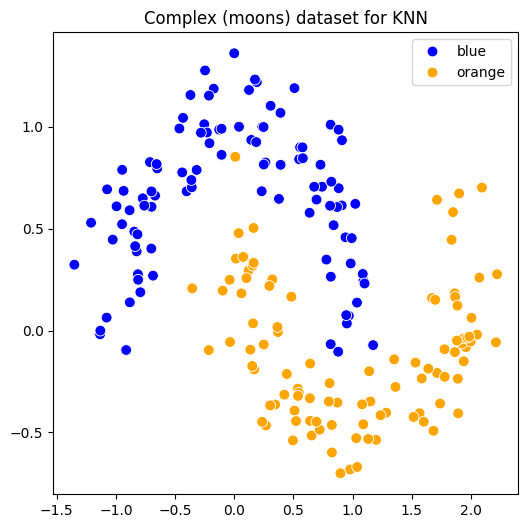

In [4]:
# Generate a more complex dataset: two moons
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=200, noise=0.15, random_state=42)
ym_labels = np.where(ym==0, 'blue', 'orange')

plt.figure(figsize=(6,6))
sns.scatterplot(x=Xm[:,0], y=Xm[:,1], hue=ym_labels, palette={'orange':'orange', 'blue':'blue'}, s=60)
plt.title('Complex (moons) dataset for KNN')
plt.show()

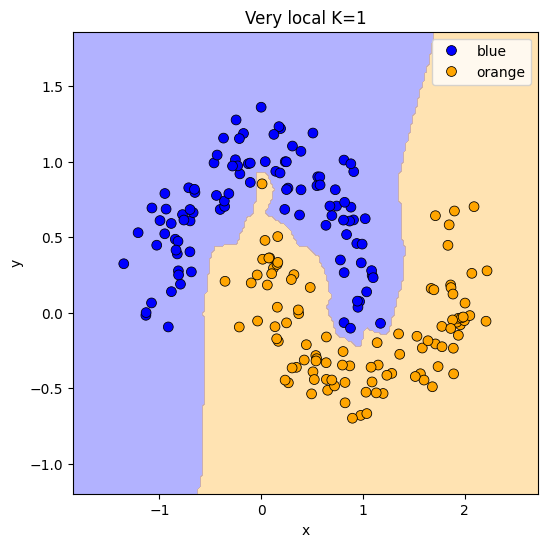

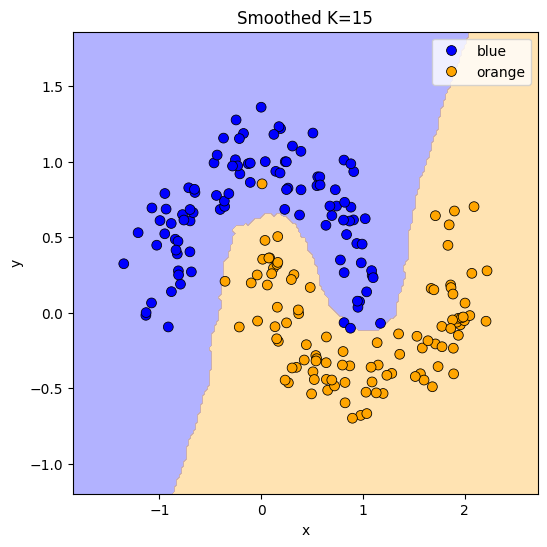

In [5]:
# Evaluate KNN prediction on a grid
def plot_knn_decision_boundary(X, y, K=5, metric='euclidean', title=None):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = []
    for point in grid:
        pred,_,_ = knn_predict(X, y, point, K=K, metric=metric)
        preds.append(pred)
    Z = np.array(preds).reshape(xx.shape)
    palette = {'orange':'orange', 'blue':'blue'}
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z=='orange', alpha=0.3, levels=1, colors=['blue', 'orange'])
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette=palette, s=50, edgecolor='k')
    plt.title(title or f'KNN Decision Boundary (K={K}, metric={metric})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plot_knn_decision_boundary(Xm, ym_labels, K=1, title='Very local K=1')
plot_knn_decision_boundary(Xm, ym_labels, K=15, title='Smoothed K=15')

#### **Test accuracy on a random test set**
- Let's split into train/test and compute accuracy, precision, and recall.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

Xtr, Xte, ytr, yte = train_test_split(Xm, ym_labels, test_size=0.3, random_state=42)
K = 5
y_pred = []
for x in Xte:
    pred, _, _ = knn_predict(Xtr, ytr, x, K=K)
    y_pred.append(pred)
acc = accuracy_score(yte, y_pred)
prec = precision_score(yte, y_pred, pos_label='orange')
rec = recall_score(yte, y_pred, pos_label='orange')
print(f'K={K}: Accuracy={acc:.2f}, Precision={prec:.2f}, Recall={rec:.2f}')

K=5: Accuracy=0.98, Precision=1.00, Recall=0.96


#### **Try Manhattan distance**

In [7]:
y_pred_m = []
for x in Xte:
    pred, _, _ = knn_predict(Xtr, ytr, x, K=K, metric='manhattan')
    y_pred_m.append(pred)
acc_m = accuracy_score(yte, y_pred_m)
print(f'Manhattan metric K={K}: Accuracy={acc_m:.2f}')

Manhattan metric K=5: Accuracy=0.98


**Which metric is better?**
- For this geometric 2D problem, Euclidean is typically more natural, but in other domains Manhattan can work better.

---
# **Support Vector Machine**
Let's step through the SVM tasks.
---
### **1. Sketch & intuition**

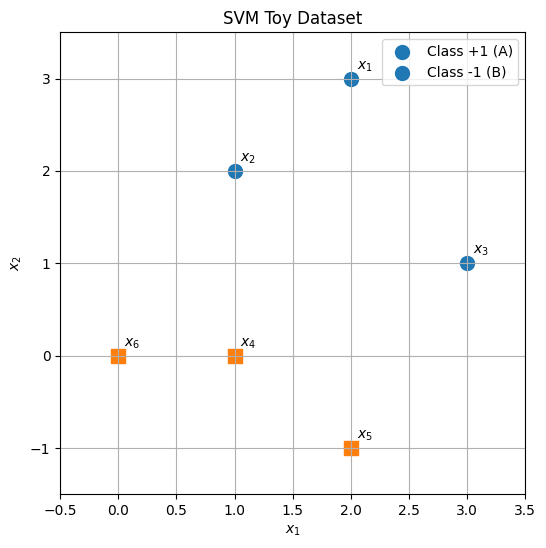

In [8]:
import matplotlib.pyplot as plt
points = np.array([[2,3],[1,2],[3,1],[1,0],[2,-1],[0,0]])
labels = np.array([+1,+1,+1,-1,-1,-1])
colors = ['C0' if y==1 else 'C1' for y in labels]
plt.figure(figsize=(6,6))
for i, (x,y) in enumerate(points):
    plt.scatter(x, y, c=colors[i], s=100, marker='o' if labels[i]==1 else 's')
    plt.text(x+0.05, y+0.1, f'$x_{{{i+1}}}$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('SVM Toy Dataset')
plt.legend(['Class +1 (A)', 'Class -1 (B)'])
plt.grid(True)
plt.xlim(-0.5, 3.5)
plt.ylim(-1.5, 3.5)
plt.show()

- **1.2:** *What does it mean for the two classes to be linearly separable?*  
  It means there exists a straight line (or hyperplane) that can perfectly separate the two classes with no misclassifications.
- **1.3:** *Are the two classes linearly separable?*  
  **Yes**, you can draw a line between the (upper right triangle) and (lower left triangle).
- **1.4:** *Margin:* The distance between the decision boundary and the closest points from either class (the support vectors).
- **1.5:** *Why maximize the margin?*  
  Maximizing margin tends to improve generalization and robustness to noise; a small margin may lead to overfitting.

---
### **2. Decision Boundary for Hard-Margin**

In [9]:
# 2.1 Write out the constraints for each observation
beta = np.array([1, -1])
beta0 = 0
constraints = []
for i, (x, y) in enumerate(zip(points, labels)):
    val = y * (np.dot(beta, x) + beta0)
    constraints.append(val)
    print(f"x_{i+1}: y={y}, value={val:.1f}, satisfied? {val >= 1}")

x_1: y=1, value=-1.0, satisfied? False
x_2: y=1, value=-1.0, satisfied? False
x_3: y=1, value=2.0, satisfied? True
x_4: y=-1, value=-1.0, satisfied? False
x_5: y=-1, value=-3.0, satisfied? False
x_6: y=-1, value=0.0, satisfied? False


Above, not all constraints are satisfied (try changing beta, beta0). Now try the second set of parameters.

In [10]:
beta = np.array([2, 2])
beta0 = -4
constraints = []
for i, (x, y) in enumerate(zip(points, labels)):
    val = y * (np.dot(beta, x) + beta0)
    constraints.append(val)
    print(f"x_{i+1}: y={y}, value={val:.1f}, satisfied? {val >= 1}")
M = 1/np.linalg.norm(beta)
print(f"Margin M = {M:.3f}")

x_1: y=1, value=6.0, satisfied? True
x_2: y=1, value=2.0, satisfied? True
x_3: y=1, value=4.0, satisfied? True
x_4: y=-1, value=2.0, satisfied? True
x_5: y=-1, value=2.0, satisfied? True
x_6: y=-1, value=4.0, satisfied? True
Margin M = 0.354


#### **2.5: Using sklearn, find the optimal decision line**

In [11]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1e6)
svm.fit(points, labels)
print(f"Estimated beta (w): {svm.coef_}")
print(f"Estimated intercept: {svm.intercept_}")
# Plot decision boundary
xx = np.linspace(-0.5, 3.5, 100)
w = svm.coef_[0]
b = svm.intercept_[0]
yy = -(w[0]*xx + b)/w[1]
plt.figure(figsize=(6,6))
for i, (x,y) in enumerate(points):
    plt.scatter(x[0], x[1], c='C0' if labels[i]==1 else 'C1', s=100, marker='o' if labels[i]==1 else 's')
plt.plot(xx, yy, 'k--', label='SVM boundary')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('SVM Decision Boundary')
plt.legend()
plt.xlim(-0.5, 3.5)
plt.ylim(-1.5, 3.5)
plt.show()

Estimated beta (w): [[0.49984 0.99968]]
Estimated intercept: [-1.49941333]


IndexError: invalid index to scalar variable.

<Figure size 600x600 with 0 Axes>

Estimated beta (w): [[0.49984 0.99968]]
Estimated intercept: [-1.49941333]


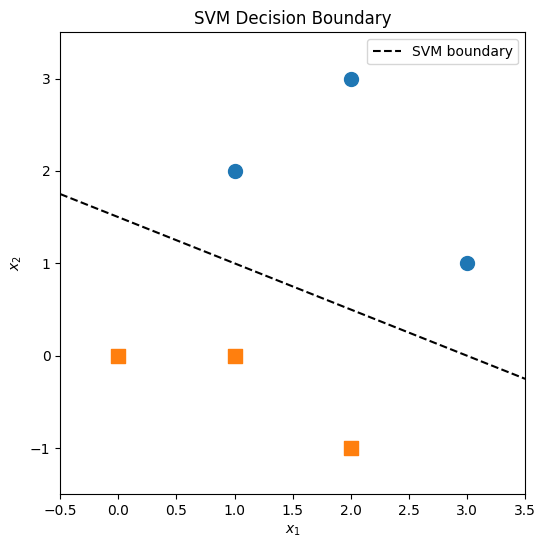

In [13]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

svm = SVC(kernel='linear', C=1e6)
svm.fit(points, labels)
print(f"Estimated beta (w): {svm.coef_}")
print(f"Estimated intercept: {svm.intercept_}")

# Plot decision boundary
xx = np.linspace(-0.5, 3.5, 100)
w = svm.coef_[0]
b = svm.intercept_[0]
yy = -(w[0]*xx + b)/w[1]

plt.figure(figsize=(6,6))
for i, (x, y) in enumerate(points):
    plt.scatter(x, y, c='C0' if labels[i]==1 else 'C1', s=100, marker='o' if labels[i]==1 else 's')
plt.plot(xx, yy, 'k--', label='SVM boundary')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('SVM Decision Boundary')
plt.legend()
plt.xlim(-0.5, 3.5)
plt.ylim(-1.5, 3.5)
plt.show()

---
### **3. Slack Variables for a Soft-Margin**

In [12]:
# Add two new points
X_soft = np.vstack([points, [[1,3],[3,-2]]])
y_soft = np.hstack([labels, [+1,-1]])
# Use previously found SVM parameters
w = svm.coef_[0]
b = svm.intercept_[0]

def hinge_loss(w, b, X, y):
    margins = y * (np.dot(X, w) + b)
    xi = np.maximum(0, 1 - margins)
    return xi, margins
xi, margins = hinge_loss(w, b, X_soft, y_soft)
for i, (m, s) in enumerate(zip(margins, xi)):
    print(f"x_{i+1}: margin={m:.2f}, slack xi={s:.2f}, violation? {s > 0}")
print(f"Total slack: {xi.sum():.2f}")

x_1: margin=2.50, slack xi=0.00, violation? False
x_2: margin=1.00, slack xi=0.00, violation? True
x_3: margin=1.00, slack xi=0.00, violation? True
x_4: margin=1.00, slack xi=0.00, violation? True
x_5: margin=1.50, slack xi=0.00, violation? False
x_6: margin=1.50, slack xi=0.00, violation? False
x_7: margin=2.00, slack xi=0.00, violation? False
x_8: margin=2.00, slack xi=0.00, violation? False
Total slack: 0.00


- Slack variable is zero for well classified points (margin > 1).
- Points violating margin (xi > 0) are within the margin or misclassified.
---
### **4. Adding Slack Variables to the Objective Function**
- Increasing C (penalty on slack) reduces margin, increases focus on minimizing classification errors (risk of overfitting).
- Decreasing C allows more margin violations, larger margin, more robust to outliers but potentially more misclassifications.

You can experiment with different values of `C` in the SVM fit above and observe the effect.

In [14]:
import numpy as np
from sklearn.svm import SVC

# Original dataset
points = np.array([
    [2,3],
    [1,2],
    [3,1],
    [1,0],
    [2,-1],
    [0,0]
])
labels = np.array([+1, +1, +1, -1, -1, -1])

# Add two new points
X_soft = np.vstack([points, [ [1,3], [3,-2] ]])
y_soft = np.hstack([labels, [+1, -1]])

# Fit a hard-margin SVM (large C) to get beta and beta0 (for demonstration)
svm = SVC(kernel='linear', C=1e6)
svm.fit(points, labels)
w = svm.coef_[0]
b = svm.intercept_[0]

# Compute hinge loss (slack variable) for each point
def hinge_loss(w, b, X, y):
    margins = y * (np.dot(X, w) + b)
    xi = np.maximum(0, 1 - margins)
    return xi, margins

xi, margins = hinge_loss(w, b, X_soft, y_soft)

# 3.1: Check for each observation if the point violates the soft-margin constraint
print("Index | x1  x2 | y | margin | slack xi | Margin violation?")
for i, (x, y, m, s) in enumerate(zip(X_soft, y_soft, margins, xi)):
    print(f"{i+1:5d} | {x[0]:.1f} {x[1]:.1f} | {y:+d} | {m:6.2f} | {s:8.2f} | {'YES' if s > 0 else 'NO'}")
print()

# 3.2: When the observation is well classified, the slack variable xi is 0 (no violation).
print("3.2: When well classified (margin >= 1), the slack variable xi = 0.\n")

# 3.3: Identify points that violate the margin
violations = np.where(xi > 0)[0]
print(f"3.3: Points that violate the margin: {[i+1 for i in violations]}")

# 3.4: Compute the total slack violation
print(f"3.4: Total Slack: {xi.sum():.2f}")

# 4. C parameter discussion
print("\n4. Discussion on C parameter:")
print("- Increasing C makes the SVM penalize slack variables more heavily, so the model tries harder to classify all points correctly, possibly at the cost of a smaller margin (risk of overfitting).")
print("- Decreasing C allows more slack (margin violations), leading to a larger margin but possibly more misclassified points (better generalization on noisy data).")

Index | x1  x2 | y | margin | slack xi | Margin violation?
    1 | 2.0 3.0 | +1 |   2.50 |     0.00 | NO
    2 | 1.0 2.0 | +1 |   1.00 |     0.00 | YES
    3 | 3.0 1.0 | +1 |   1.00 |     0.00 | YES
    4 | 1.0 0.0 | -1 |   1.00 |     0.00 | YES
    5 | 2.0 -1.0 | -1 |   1.50 |     0.00 | NO
    6 | 0.0 0.0 | -1 |   1.50 |     0.00 | NO
    7 | 1.0 3.0 | +1 |   2.00 |     0.00 | NO
    8 | 3.0 -2.0 | -1 |   2.00 |     0.00 | NO

3.2: When well classified (margin >= 1), the slack variable xi = 0.

3.3: Points that violate the margin: [np.int64(2), np.int64(3), np.int64(4)]
3.4: Total Slack: 0.00

4. Discussion on C parameter:
- Increasing C makes the SVM penalize slack variables more heavily, so the model tries harder to classify all points correctly, possibly at the cost of a smaller margin (risk of overfitting).
- Decreasing C allows more slack (margin violations), leading to a larger margin but possibly more misclassified points (better generalization on noisy data).
